# Make word-doc matrix

In [1]:
import datetime as dt
import os
import time

In [15]:
from cltk.corpus.greek.tlg.parse_tlg_indices import get_epithet_index
from cltk.corpus.greek.tlg.parse_tlg_indices import get_epithets
from cltk.corpus.greek.tlg.parse_tlg_indices import select_authors_by_epithet
from cltk.corpus.greek.tlg.parse_tlg_indices import get_epithet_of_author
from cltk.corpus.greek.tlg.parse_tlg_indices import get_id_author
from cltk.stop.greek.stops import STOPS_LIST as greek_stops
from cltk.tokenize.word import nltk_tokenize_words

from greek_accentuation.characters import base

import pandas  # pip install pandas

from sklearn.decomposition import NMF  # pip install scikit-learn scipy
from sklearn.externals import joblib
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer

In [3]:
def stream_lemmatized_files(corpus_dir):
    # return all docs in a dir
    user_dir = os.path.expanduser('~/cltk_data/user_data/' + corpus_dir)
    files = os.listdir(user_dir)

    for file in files:
        filepath = os.path.join(user_dir, file)
        with open(filepath) as fo:
            yield fo.read()

In [4]:
def map_file_order_to_name(corpus_dir):
    # read contents of dir, order and their tlg name
    user_dir = os.path.expanduser('~/cltk_data/user_data/' + corpus_dir)
    files = os.listdir(user_dir)
    
    map_id_author = get_id_author()  # {…, '1648': 'Pyrgion Hist.', '4017': 'Syrianus Phil.', …}

    map_count_name = {}
    for count, file in enumerate(files):
        file_id = str(file[3:-4])
        name = map_id_author[file_id]
        map_count_name[count] = name
    
    return map_count_name

In [5]:
map_file_count_name = map_file_order_to_name('tlg_lemmatized_no_accents_no_stops')

In [6]:
t0 = dt.datetime.utcnow()

data_samples = []
for text in stream_lemmatized_files('tlg_lemmatized_no_accents_no_stops'):
    data_samples.append(text)

print('... finished in {}'.format(dt.datetime.utcnow() - t0))
print('Number of texts:', len(data_samples))

... finished in 0:00:04.009329
Number of texts: 1823


In [7]:
# view all epithets:
get_epithets()

['Alchemistae',
 'Apologetici',
 'Astrologici',
 'Astronomici',
 'Atticistae',
 'Biographi',
 'Bucolici',
 'Choliambographi',
 'Chronographi',
 'Comici',
 'Doxographi',
 'Elegiaci',
 'Epici/-ae',
 'Epigrammatici/-ae',
 'Epistolographi',
 'Geographi',
 'Geometri',
 'Gnomici',
 'Gnostici',
 'Grammatici',
 'Hagiographi',
 'Historici/-ae',
 'Hymnographi',
 'Iambici',
 'Lexicographi',
 'Lyrici/-ae',
 'Mathematici',
 'Mechanici',
 'Medici',
 'Mimographi',
 'Musici',
 'Mythographi',
 'Nomographi',
 'Onirocritici',
 'Oratores',
 'Paradoxographi',
 'Parodii',
 'Paroemiographi',
 'Periegetae',
 'Philologi',
 'Philosophici/-ae',
 'Poetae',
 'Poetae Didactici',
 'Poetae Medici',
 'Poetae Philosophi',
 'Polyhistorici',
 'Rhetorici',
 'Scriptores Ecclesiastici',
 'Scriptores Erotici',
 'Scriptores Fabularum',
 'Scriptores Rerum Naturalium',
 'Sophistae',
 'Tactici',
 'Theologici',
 'Tragici']

In [17]:
t0 = dt.datetime.utcnow()

# tf-idf features
n_samples = 2000
n_features = 1000  # TODO: increase
n_topics = len(get_epithets())
n_top_words = 20

tfidf_vectorizer = TfidfVectorizer(max_df=1.0, 
                                   min_df=1,
                                   max_features=n_features,
                                   stop_words=None)
tfidf = tfidf_vectorizer.fit_transform(data_samples)

# save features
vector_fp = os.path.expanduser('~/cltk_data/user_data/tlg_lemmatized_no_accents_no_stops_tfidf_{0}features.pickle'.format(n_features))
joblib.dump(tfidf, vector_fp)

print('... finished in {}'.format(dt.datetime.utcnow() - t0))
# time on good server:
# 1000 features: 0:01:22

... finished in 0:01:29.587684


# Run model

In [45]:
t0 = dt.datetime.utcnow()

print("Fitting the NMF model with tf-idf features, "
      "n_samples=%d and n_features=%d..."
      % (n_samples, n_features))
nmf = NMF(n_components=n_topics, random_state=1,
          alpha=.1, l1_ratio=.5).fit(tfidf)

# save model
nmf_fp = os.path.expanduser('~/cltk_data/user_data/tlg_lemmatized_no_accents_no_stops_tfidf_{0}features_nmf.pickle'.format(n_features))
joblib.dump(nmf, nmf_fp)

print('... finished in {}'.format(dt.datetime.utcnow() - t0))

Fitting the NMF model with tf-idf features, n_samples=2000 and n_features=1000...
... finished in 0:00:16.540701


In [13]:
def print_top_words(model, feature_names, n_top_words):
    for topic_id, topic in enumerate(model.components_):
        print('Topic #{}:'.format(int(topic_id)))
        print(''.join([feature_names[i] + ' ' + str(round(topic[i], 2))
              +' | ' for i in topic.argsort()[:-n_top_words - 1:-1]]))
        print()

In [14]:
print("Topics in NMF model:")
tfidf_feature_names = tfidf_vectorizer.get_feature_names()

print_top_words(nmf, tfidf_feature_names, n_top_words)

Topics in NMF model:
Topic #0:
ειμι 2.56 | ου 2.44 | τος 1.3 | αυ 1.04 | εχω 0.96 | τας 0.68 | αλλ 0.53 | δεω1 0.46 | τουτων 0.43 | ποιεω 0.43 | εαυτου 0.39 | εγω 0.39 | ωσπερ 0.37 | πα 0.36 | καθ 0.34 | ουδεν 0.33 | οσος 0.32 | ολοξ 0.32 | παντα 0.32 | ευ 0.31 | 

Topic #1:
αυ 3.58 | τος 3.51 | αυτον 0.81 | αυτους 0.34 | αυτην 0.28 | τας 0.27 | εκει 0.23 | ειμι 0.21 | γαι 0.2 | τοτε 0.18 | ου 0.17 | εαυτου 0.17 | εγενετο 0.16 | ερχομαι 0.14 | τουτου 0.14 | μετ 0.14 | ηως 0.14 | εχω 0.14 | αδελφος 0.14 | πολυς 0.13 | 

Topic #2:
εγω 4.18 | νυ 0.41 | εμεω 0.33 | εμοι 0.23 | εμε 0.22 | σευω 0.18 | οπως 0.18 | παρ 0.18 | οιδα 0.16 | ουδεν 0.14 | σοι 0.14 | ου 0.14 | πως 0.12 | αλλ 0.12 | σεω 0.12 | οραω 0.12 | ερχομαι 0.11 | ταυτ 0.11 | καγω 0.1 | ειπε 0.1 | 

Topic #3:
φημι 3.37 | αυτον 0.44 | ειμι 0.36 | πρωτω 0.26 | φησι 0.25 | γενεσθαι 0.23 | λεγει 0.22 | φησιν 0.22 | φασι 0.22 | ιστορεω 0.2 | καθα 0.2 | αθηνη 0.17 | υστερος 0.16 | ποτε 0.16 | ομηρος 0.15 | λεγεται 0.14 | αθηναι 0.13 

In [18]:
tfidf.shape

(1823, 1000)

In [19]:
doc_topic_distrib = nmf.transform(tfidf)  # numpy.ndarray

In [20]:
doc_topic_distrib.shape

(1823, 55)

In [21]:
df = pandas.DataFrame(doc_topic_distrib)

In [22]:
df = df.rename(map_file_count_name)

Questions:

* to what topic does each author most belong? (and how to determine cutoff?)
* what authors most exemplify a topic?

In [23]:
df.head(100)

,0,1,2,3,4,5,6,7,8,9,...,45,46,47,48,49,50,51,52,53,54
Lepidus Hist.,0.000000,0.052397,0.000000,0.062234,0.037794,0.016243,0.000000,0.000000,0.116812,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0
Melito Trag.,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0
[Polyidus] Trag.,0.009829,0.000000,0.000000,0.000000,0.117318,0.006644,0.072198,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0
Archippus Comic.,0.029340,0.006394,0.044214,0.000000,0.046676,0.027693,0.052116,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.021334,0.037267,0.003425,0.000000,0.000000,0.000000,0.0
Martyrium Potamiaenae Et Basilidis,0.014648,0.114285,0.000000,0.000000,0.022638,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.025779,0.000000,0.000000,0.000000,0.0
Acta Phileae,0.023905,0.016101,0.004572,0.000000,0.019957,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.002361,0.000000,0.000000,0.000000,0.021107,0.000000,0.000000,0.000000,0.0
Menecrates Hist.,0.025446,0.077462,0.000000,0.000000,0.010925,0.000000,0.008107,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.009374,0.000000,0.036557,0.000000,0.0
Marinus Phil.,0.108062,0.021171,0.012125,0.000000,0.000000,0.000000,0.004722,0.000000,0.000000,0.000000,...,0.000000,0.024151,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0
Troilus Soph.,0.117505,0.000000,0.000000,0.017368,0.000000,0.000000,0.015038,0.005064,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.004749,0.000000,0.0
Apollinaris Theol.,0.085026,0.053653,0.000932,0.011957,0.021573,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.006054,0.000000,0.000000,0.000000,0.000000,0.194749,0.000000,0.000000,0.000000,0.0


In [24]:
# for each topic (col), which author (row) has the highest value?
# TODO: get top 5 authors

for count in range(n_topics):
    print('Top author of topic {0}: {1}'.format(count, df[count].idxmax()))

Top author of topic 0: Joannes Rhet.
Top author of topic 1: Joannes Malalas Chronogr.
Top author of topic 2: Alcibiades [Eleg.]
Top author of topic 3: Pythaenetus Hist.
Top author of topic 4: Eubulides Comic.
Top author of topic 5: Quintus Epic.
Top author of topic 6: Arrianus Epic.
Top author of topic 7: Lexicon αἱμωδεῖν
Top author of topic 8: Capito Hist.
Top author of topic 9: Lexicon Vindobonense
Top author of topic 10: Melanthius Trag.
Top author of topic 11: Serenus Geom.
Top author of topic 12: Atridarum Reditus
Top author of topic 13: Chronographiae Anonymae
Top author of topic 14: Eudoxus Hist.
Top author of topic 15: Diogenes Phil.
Top author of topic 16: Acta Phileae
Top author of topic 17: Eudromus Phil.
Top author of topic 18: [Alexarchus] Hist.
Top author of topic 19: Timaeus Praxidas Astrol.
Top author of topic 20: Dosiadas Lyr.
Top author of topic 21: Carneiscus Phil.
Top author of topic 22: [Sodamus] Eleg.
Top author of topic 23: Danaïs vel Danaïdes
Top author of topic

In [25]:
# Now, transpose df and get top topic of each author
# for each topic (col), which author (row) has the highest value?
# TODO: get top 5 authors
df_t = df.T

In [26]:
df_t.head(10)

,Lepidus Hist.,Melito Trag.,[Polyidus] Trag.,Archippus Comic.,Martyrium Potamiaenae Et Basilidis,Acta Phileae,Menecrates Hist.,Marinus Phil.,Troilus Soph.,Apollinaris Theol.,...,Hesiodus Epic.,Marcus Aurelius Antoninus Imperator Phil.,Alexinus Phil.,Menodotus Hist.,Autolycus Astron.,[Eurytus] Phil.,Lycophronides Lyr.,Parthax Hist.,Evangelium Bartholomaei,Nausicrates Comic.
0,0.000000,0.0,0.009829,0.029340,0.014648,0.023905,0.025446,0.108062,0.117505,0.085026,...,0.014831,0.156837,0.0,0.071611,0.021045,0.059518,0.000000,0.000000,0.010503,0.011175
1,0.052397,0.0,0.000000,0.006394,0.114285,0.016101,0.077462,0.021171,0.000000,0.053653,...,0.023909,0.005707,0.0,0.042453,0.005230,0.000000,0.000000,0.002172,0.107256,0.040556
2,0.000000,0.0,0.000000,0.044214,0.000000,0.004572,0.000000,0.012125,0.000000,0.000932,...,0.000000,0.007171,0.0,0.019488,0.000000,0.001908,0.034305,0.000000,0.073055,0.000000
3,0.062234,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.017368,0.011957,...,0.003157,0.000000,0.0,0.051213,0.000000,0.000657,0.000000,0.000000,0.000000,0.030323
4,0.037794,0.0,0.117318,0.046676,0.022638,0.019957,0.010925,0.000000,0.000000,0.021573,...,0.022081,0.021367,0.0,0.004193,0.011355,0.013463,0.074888,0.000000,0.015270,0.000000
5,0.016243,0.0,0.006644,0.027693,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.272712,0.000000,0.0,0.012128,0.000000,0.001100,0.018942,0.000000,0.000000,0.000000
6,0.000000,0.0,0.072198,0.052116,0.000000,0.000000,0.008107,0.004722,0.015038,0.000000,...,0.033298,0.000000,0.0,0.010301,0.000000,0.004449,0.000000,0.000000,0.000000,0.000000
7,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.005064,0.000000,...,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
8,0.116812,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.083994,0.000000,0.000000
9,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000


In [27]:
map_name_epithet_id = {}
for curr_name in df_t.columns:
    print(curr_name)
    try:
        top_topic = int(df_t[curr_name].idxmax())
    except TypeError:  # there are some duplicate names, just take one value for now
        top_topic = int(df_t[curr_name].idxmax().iloc[0])    
    print('    NMF topic:', top_topic)
    for _id, name in get_id_author().items():
        if curr_name == name:
            epithet = get_epithet_of_author(_id)
            print('    Traditional epithet:', epithet)
            map_name_epithet_id[name] = {'id': _id,
                                        'top_topic': top_topic,
                                        'epithet': epithet}
    print()

Lepidus Hist.
    NMF topic: 8
    Traditional epithet: Historici/-ae

Melito Trag.
    NMF topic: 0
    Traditional epithet: Tragici

[Polyidus] Trag.
    NMF topic: 4
    Traditional epithet: Tragici

Archippus Comic.
    NMF topic: 12
    Traditional epithet: Comici

Martyrium Potamiaenae Et Basilidis
    NMF topic: 1
    Traditional epithet: None

Acta Phileae
    NMF topic: 16
    Traditional epithet: None

Menecrates Hist.
    NMF topic: 14
    Traditional epithet: Historici/-ae
    Traditional epithet: Historici/-ae
    Traditional epithet: Historici/-ae
    Traditional epithet: Historici/-ae
    Traditional epithet: Historici/-ae

Marinus Phil.
    NMF topic: 0
    Traditional epithet: Philosophici/-ae

Troilus Soph.
    NMF topic: 0
    Traditional epithet: Sophistae

Apollinaris Theol.
    NMF topic: 50
    Traditional epithet: Theologici

Antileon Hist.
    NMF topic: 42
    Traditional epithet: Historici/-ae

Hermas Scr. Eccl., Pastor Hermae
    NMF topic: 1
    Traditional

Now let's look at the variations of the respective clusters, nmf topic and epithets

* Question: Which topics are found within each epithet?
* Question: Which epithets are found within each topic? And how many?

In [28]:
map_name_epithet_id['Silenus Trag.']

{'epithet': 'Tragici', 'id': '0603', 'top_topic': 0}

In [29]:
# Group by epithet, collect topics
# {<epithet>: [<topics>]}
from collections import defaultdict

map_epithet_topics = defaultdict(list)
for name, _dict in map_name_epithet_id.items():
    epithet = _dict['epithet']
    top_topic = _dict['top_topic']
    map_epithet_topics[epithet].append(top_topic)

In [30]:
# import pprint
# pp = pprint.PrettyPrinter(indent=4)
# pp.pprint(dict(map_epithet_topics))
print(dict(map_epithet_topics))

{'Epigrammatici/-ae': [53, 6, 20, 5, 15, 43, 34, 54, 39, 34, 31, 54, 34, 19, 6, 2, 43, 7, 48, 48, 43, 39], 'Lyrici/-ae': [5, 5, 21, 21, 50, 47, 5, 0, 19, 42, 37, 0, 6, 5, 29, 0, 0, 0, 39, 2, 4, 2, 2, 5, 48, 0, 53, 0, 28, 46, 2, 5, 18, 34, 21, 53, 1, 20, 19, 24, 5, 53, 5, 46, 14, 17, 5, 4, 32, 0, 39, 21, 45], 'Atticistae': [9, 7, 0, 54], 'Elegiaci': [2, 5, 11, 5, 5, 0, 54, 30, 46, 54, 0, 12, 4, 54, 6, 6, 5, 22, 49, 11, 39, 5, 36, 35, 5, 5, 5], 'Gnomici': [5, 5, 6, 48], 'Scriptores Erotici': [0, 0, 0, 0, 0, 51, 51, 0], 'Chronographi': [13, 1, 1, 13, 1, 13], 'Oratores': [0, 0, 0, 0, 0, 0, 0, 44, 0, 0, 0, 0], 'Philosophici/-ae': [0, 36, 12, 31, 0, 0, 22, 0, 0, 47, 2, 0, 50, 37, 0, 0, 41, 18, 28, 0, 0, 0, 4, 0, 0, 44, 0, 0, 13, 6, 0, 0, 21, 12, 1, 5, 49, 0, 0, 48, 0, 0, 46, 0, 0, 0, 0, 0, 0, 31, 1, 0, 0, 28, 50, 0, 0, 0, 6, 28, 0, 0, 0, 48, 24, 0, 44, 0, 0, 4, 0, 0, 21, 0, 0, 0, 45, 0, 0, 31, 0, 0, 3, 0, 0, 0, 15, 47, 3, 8, 0, 50, 0, 0, 0, 29, 0, 13, 33, 0, 44, 0, 3, 0, 21, 16, 0, 0, 3, 26,

In [50]:
# which epithet has the most topics associated with it?
map_epithet_count_topics = {}
for epithet, topic_list in map_epithet_topics.items():
    map_epithet_count_topics[epithet] = len(topic_list)

sorted(map_epithet_count_topics.items(), key=lambda x:x[1], reverse=True)

[(None, 334),
 ('Historici/-ae', 309),
 ('Philosophici/-ae', 208),
 ('Comici', 149),
 ('Tragici', 80),
 ('Grammatici', 70),
 ('Epici/-ae', 57),
 ('Lyrici/-ae', 53),
 ('Scriptores Ecclesiastici', 48),
 ('Medici', 43),
 ('Sophistae', 41),
 ('Rhetorici', 39),
 ('Theologici', 32),
 ('Elegiaci', 29),
 ('Poetae', 29),
 ('Alchemistae', 22),
 ('Epigrammatici/-ae', 22),
 ('Astronomici', 13),
 ('Iambici', 13),
 ('Geographi', 12),
 ('Oratores', 11),
 ('Mathematici', 11),
 ('Epistolographi', 10),
 ('Astrologici', 10),
 ('Periegetae', 9),
 ('Paradoxographi', 9),
 ('Apologetici', 9),
 ('Scriptores Erotici', 8),
 ('Poetae Philosophi', 8),
 ('Mechanici', 7),
 ('Biographi', 7),
 ('Mythographi', 6),
 ('Philologi', 6),
 ('Tactici', 6),
 ('Chronographi', 6),
 ('Paroemiographi', 5),
 ('Parodii', 5),
 ('Gnomici', 4),
 ('Atticistae', 4),
 ('Musici', 4),
 ('Poetae Medici', 4),
 ('Geometri', 4),
 ('Lexicographi', 3),
 ('Bucolici', 3),
 ('Mimographi', 2),
 ('Gnostici', 2),
 ('Doxographi', 2),
 ('Scriptores Fabu

In [32]:
# Group by topic, collect epithets
# {<topic>: [<epithets>]}
from collections import defaultdict

map_topic_epithets = defaultdict(list)
for name, _dict in map_name_epithet_id.items():
    epithet = _dict['epithet']
    top_topic = _dict['top_topic']
    map_topic_epithets[top_topic].append(epithet)

In [33]:
dict(map_topic_epithets)

{0: [None,
  'Scriptores Erotici',
  'Philosophici/-ae',
  'Grammatici',
  'Tragici',
  'Medici',
  'Musici',
  'Comici',
  'Poetae Philosophi',
  None,
  'Comici',
  'Comici',
  'Tragici',
  'Philosophici/-ae',
  'Philosophici/-ae',
  'Philosophici/-ae',
  'Philosophici/-ae',
  None,
  None,
  'Philosophici/-ae',
  None,
  'Rhetorici',
  'Philosophici/-ae',
  'Medici',
  'Alchemistae',
  'Philosophici/-ae',
  'Epici/-ae',
  'Sophistae',
  None,
  None,
  'Poetae',
  None,
  'Tactici',
  'Tragici',
  'Sophistae',
  None,
  'Poetae',
  'Medici',
  'Lyrici/-ae',
  'Philosophici/-ae',
  'Philosophici/-ae',
  'Biographi',
  'Sophistae',
  'Poetae',
  'Philosophici/-ae',
  'Medici',
  'Philosophici/-ae',
  'Philosophici/-ae',
  'Sophistae',
  'Comici',
  'Tragici',
  'Epici/-ae',
  'Philosophici/-ae',
  None,
  'Rhetorici',
  'Rhetorici',
  'Historici/-ae',
  'Comici',
  'Philosophici/-ae',
  None,
  None,
  'Rhetorici',
  'Sophistae',
  'Tragici',
  'Scriptores Ecclesiastici',
  'Tactici',

In [44]:
# least, most cohesive epithets
# which epithet has the most topics associated with it?
map_topics_count_epithet = {}
for topic, epithet_list in map_topic_epithets.items():
    map_topics_count_epithet[topic] = len(epithet_list)

# map_topics_count_epithet
sorted_list_tuples = sorted(map_topics_count_epithet.items(), key=lambda x:x[1], reverse=True)
for topic_freq in sorted_list_tuples:
    topic_number = str(topic_freq[0])
    doc_freq = str(topic_freq[1])
    print('Topic #{0} has {1} author-documents in it'.format(topic_number, doc_freq))

Topic #0 has 493 author-documents in it
Topic #1 has 109 author-documents in it
Topic #5 has 105 author-documents in it
Topic #50 has 105 author-documents in it
Topic #2 has 63 author-documents in it
Topic #3 has 55 author-documents in it
Topic #18 has 38 author-documents in it
Topic #8 has 35 author-documents in it
Topic #4 has 33 author-documents in it
Topic #6 has 30 author-documents in it
Topic #9 has 28 author-documents in it
Topic #28 has 28 author-documents in it
Topic #30 has 27 author-documents in it
Topic #31 has 27 author-documents in it
Topic #11 has 25 author-documents in it
Topic #7 has 22 author-documents in it
Topic #19 has 22 author-documents in it
Topic #27 has 21 author-documents in it
Topic #16 has 20 author-documents in it
Topic #25 has 20 author-documents in it
Topic #13 has 19 author-documents in it
Topic #20 has 18 author-documents in it
Topic #21 has 18 author-documents in it
Topic #39 has 18 author-documents in it
Topic #15 has 17 author-documents in it
Topic 

In [46]:
# also do this all w/ countvectorizer?

In [47]:
# http://scikit-learn.org/stable/modules/clustering.html

In [48]:
dataset_array = df.values
print(dataset_array.dtype)  # kmeans needs to be homogeneous data type (here, float64)
print(dataset_array)

float64
[[ 0.          0.05239734  0.         ...,  0.          0.          0.        ]
 [ 0.          0.          0.         ...,  0.          0.          0.        ]
 [ 0.00982926  0.          0.         ...,  0.          0.          0.        ]
 ..., 
 [ 0.          0.00217153  0.         ...,  0.          0.          0.        ]
 [ 0.01050317  0.10725617  0.07305529 ...,  0.          0.          0.        ]
 [ 0.01117548  0.04055595  0.         ...,  0.0597499   0.          0.        ]]


In [49]:
# do I need to normalize
# sklearn.preprocessing.StandardScaler
from sklearn import preprocessing

In [50]:
# http://scikit-learn.org/stable/modules/preprocessing.html
# first load scaler and train on given data set
scaler = preprocessing.StandardScaler().fit(df)

In [51]:
scaler.mean_

array([ 0.04901517,  0.02739097,  0.0158077 ,  0.01366609,  0.01608483,
        0.01865701,  0.01061474,  0.0051218 ,  0.00666087,  0.00560527,
        0.00876906,  0.00541008,  0.00350985,  0.00433349,  0.00377157,
        0.00716148,  0.00601332,  0.00635522,  0.00765168,  0.00520384,
        0.00419841,  0.00432905,  0.00292568,  0.00423707,  0.00577587,
        0.00504105,  0.00622198,  0.00691197,  0.00818045,  0.00500131,
        0.00576806,  0.01860691,  0.00446472,  0.00215022,  0.00453086,
        0.00470665,  0.00465496,  0.00353856,  0.00213449,  0.00324078,
        0.00343465,  0.0043699 ,  0.00297837,  0.00292783,  0.00491088,
        0.00357567,  0.00483611,  0.0037335 ,  0.00297435,  0.00327716,
        0.01355246,  0.00233118,  0.00380632,  0.00410167,  0.00290983])

In [52]:
scaler.scale_

array([ 0.04617582,  0.03350082,  0.02792515,  0.02649149,  0.02276127,
        0.03690022,  0.02053325,  0.02643818,  0.03075625,  0.02656803,
        0.01989261,  0.03050725,  0.02117749,  0.02620735,  0.01663647,
        0.02016398,  0.02065356,  0.01737012,  0.0254745 ,  0.02604527,
        0.01845541,  0.02078991,  0.01989431,  0.0238357 ,  0.01918127,
        0.027815  ,  0.02155526,  0.01931634,  0.02418206,  0.01731953,
        0.02311142,  0.02159508,  0.0190932 ,  0.01855774,  0.0205096 ,
        0.01732579,  0.01785835,  0.02083252,  0.02768965,  0.02177008,
        0.01935923,  0.01687883,  0.02230138,  0.02236417,  0.01908085,
        0.0163316 ,  0.01557187,  0.01907033,  0.0191739 ,  0.01951278,
        0.03591642,  0.02217018,  0.01690821,  0.02051748,  0.02301206])

In [53]:
t0 = dt.datetime.utcnow()

# actually do normalization; can be reused for eg a training set
df_scaled = pandas.DataFrame(scaler.transform(df))

print('... finished in {}'.format(dt.datetime.utcnow() - t0))

... finished in 0:00:00.034728


# Visualize topic clusters

In [55]:
from sklearn import cluster

In [56]:
# Convert DataFrame to matrix (numpy.ndarray)
matrix = df_scaled.as_matrix()

km = cluster.KMeans(n_clusters=n_topics)
km.fit(matrix)

# Get cluster assignment labels
labels = km.labels_  # these are the topics 0-54; array([53, 53, 16, ..., 42, 16, 13]

# Format results as a DataFrame
df_clusters = pandas.DataFrame([df_scaled.index, labels]).T  # add author names to the 0 col

In [57]:
df_clusters.head(5)

,0,1
0,0,14
1,1,3
2,2,41
3,3,44
4,4,50


In [60]:
%matplotlib inline
import matplotlib.pyplot as plt  # pip install matplotlib
import matplotlib
matplotlib.style.use('ggplot')

# from pandas.tools.plotting import table

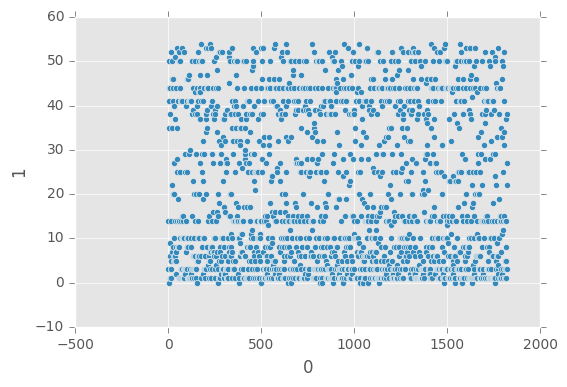

In [61]:
# this is a cluseter of the already-clustered kmeans topics; not very informative
plt.figure()
df_clusters.plot.scatter(x=0, y=1)  # y is topics no., x is doc id

## Kmeans based tfidf matrix

In [65]:
# try clustering the original tfidf
# tfidf_dense = tfidf.toarray()
scaler = preprocessing.StandardScaler(with_mean=False).fit(tfidf) # either with_mean=False or make dense

# save scaler
scaler_fp = os.path.expanduser('~/cltk_data/user_data/tlg_lemmatized_no_accents_no_stops_tfidf_{0}features_scaler.pickle'.format(n_features))
joblib.dump(df_scaled, scaler_fp)

['/root/cltk_data/user_data/tlg_lemmatized_no_accents_no_stops_tfidf_1000features_scaler.pickle']

In [73]:
import numpy as np

In [77]:
# direct Pandas conversion of sparse scipy matrix not supported
# Following http://stackoverflow.com/a/17819427
# df_scaled_tfidf = pandas.DataFrame(scaler.transform(tfidf))
# df_scaled_tfidf = pandas.DataFrame()

scaler_tfidf = scaler.transform(tfidf)  # sparse matrix of type '<class 'numpy.float64'>
pandas.SparseDataFrame([pandas.SparseSeries(scaler_tfidf[i].toarray().ravel()) for i in np.arange(scaler_tfidf.shape[0])])
df_scaled_tfidf = pandas.SparseDataFrame([pandas.SparseSeries(scaler_tfidf[i].toarray().ravel()) for i in np.arange(scaler_tfidf.shape[0])])
# type(df)  # pandas.sparse.frame.SparseDataFrame

In [78]:
# Convert DataFrame to matrix (numpy.ndarray)
matrix_tfidf = df_scaled_tfidf.as_matrix()

km_tfidf = cluster.KMeans(n_clusters=n_topics)
km_tfidf.fit(matrix_tfidf)

# Get cluster assignment labels
labels = km_tfidf.labels_  # these are the topics 0-54; array([53, 53, 16, ..., 42, 16, 13]

# Format results as a DataFrame
df_clusters_tfidf = pandas.DataFrame([df_scaled_tfidf.index, labels]).T  # add author names to the 0 col

In [82]:
df_clusters_tfidf.head(10)

,0,1
0,0,9
1,1,9
2,2,9
3,3,22
4,4,48
5,5,9
6,6,48
7,7,26
8,8,4
9,9,37


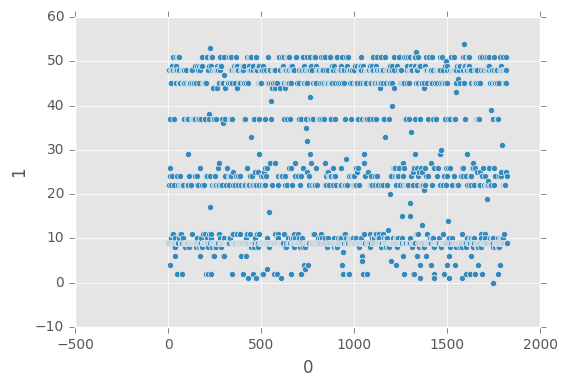

In [83]:
plt.figure()
df_clusters_tfidf.plot.scatter(x=0, y=1)  # y is topics no., x is doc id

## Kmeans based on nmf

In [84]:
nmf_array = nmf.components_

In [85]:
t0 = dt.datetime.utcnow()

# nmf_dense = nmf_array.toarray()
scaler = preprocessing.StandardScaler().fit(nmf_array) # either with_mean=False or make dense

# save features
tfidf_matrix_scaler_fp = os.path.expanduser('~/cltk_data/user_data/tlg_lemmatized_no_accents_no_stops_tfidf_matrix_{0}features.pickle'.format(n_features))
joblib.dump(scaler, tfidf_matrix_scaler_fp)

print('... finished in {}'.format(dt.datetime.utcnow() - t0))

... finished in 0:00:00.014131


In [86]:
df_scaled_nmf = pandas.DataFrame(scaler.transform(nmf_array))

In [87]:
# Convert DataFrame to matrix (numpy.ndarray)
matrix_nmf = df_scaled_nmf.as_matrix()

km_nmf = cluster.KMeans(n_clusters=n_topics)
km_nmf.fit(matrix_nmf)

# Get cluster assignment labels
labels = km_nmf.labels_  # these are the clusters 0-54; array([ 1,  4, 11, 14, 28,  9, 30,

# Format results as a DataFrame
df_clusters_nmf = pandas.DataFrame([df_scaled_nmf.index, labels]).T  # add author names to the 0 col

In [91]:
df_clusters_nmf.head(10)

,0,1
0,0,1
1,1,6
2,2,13
3,3,4
4,4,16
5,5,5
6,6,23
7,7,14
8,8,20
9,9,19


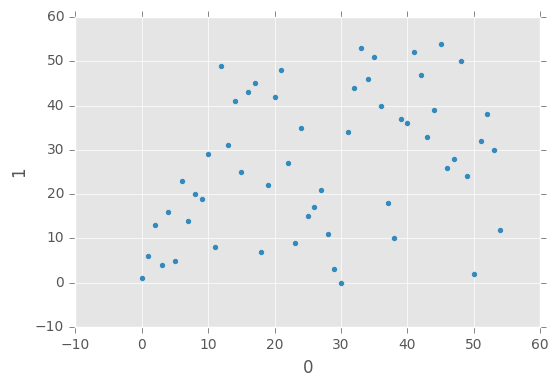

In [89]:
plt.figure()
df_clusters_nmf.plot.scatter(x=0, y=1)  # y is topics no., x is doc id